## Setup
### Project setup

In [191]:
if run_init:
    %pip install -U pip
    !if  [ ! -d "deep-learning-project" ] ; then git clone https://github.com/albertsgarde/deep-learning-project.git; fi
    !cd deep-learning-project && git reset --hard && git pull && git checkout Fix_guitar_json && git pull
    !source deep-learning-project/setup.sh deep-learning-project
    import os
    os.chdir("deep-learning-project/deep-learning")
run_init = False

In [192]:
run_init = True

In [193]:
run_init = False

### Imports

In [194]:
import matplotlib.pyplot as plt
import IPython.display as display

import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as nn_func
import torch.optim as optim
from torch.autograd import Variable

import audio_samples_py as aus

import utils.plots as plots
import utils.criterion as chord_criterion
import utils.utils as utils

### Device setup

In [195]:
device, use_cuda = utils.setup_device(use_cuda_if_possible = True)

Running GPU.


## Data

### Synth parameters

In [196]:
SAMPLE_LENGTH = 1024
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.5
SEED = 1 # Generates different data if changed. Useful to ensure that a result isn't a fluke.

possible_chord_types = [i for i in range(aus.num_chord_types())]
octave_parameters = aus.OctaveParameters(add_root_octave_probability=0.5,
        add_other_octave_probability=0.3)
parameters = aus.DataParameters(num_samples=SAMPLE_LENGTH, octave_parameters=octave_parameters, min_frequency=50, max_frequency=2000, min_frequency_std_dev=0.5, max_frequency_std_dev=3., possible_chord_types=possible_chord_types) \
    .add_sine(probability=0.5, amplitude_range=(0.1,0.2)) \
    .add_saw(probability=0.5, amplitude_range=(0.1, 0.2)) \
    .add_pulse(probability=0.5, amplitude_range=(0.1, 0.2), duty_cycle_range=(0.1, 0.9)) \
    .add_triangle(probability=0.5, amplitude_range=(0.1, 0.2)) \
    .add_noise(probability=1, amplitude_range=(0.001, 0.04)) \
    .apply_distortion(probability=0.5, power_range=(0.1, 20)) \
    .apply_normalization(probability=1)

### Loading

In [197]:
def init_rw_data(path, label_to_target, validation_size: float, batch_size: int):
    assert validation_size >= 0, f"validation size must be non-negative. validation_size={validation_size}"
    assert validation_size <= 1, f"validation size must be no greater than 1. validation_size={validation_size}"
    assert batch_size > 0, f"batch_size must be positive. batch_size={batch_size}"

    data_loader_params = {"batch_size": batch_size, "collate_fn": utils.custom_collate, "shuffle": True, "drop_last": True}

    # Not a mistake. Just an artifact of how random_partition works.
    training_data, validation_data = aus.load_data_set(path).random_partition(1-validation_size)

    training_data = utils.AudioRwDataSet(training_data, label_to_target)
    validation_data = utils.AudioRwDataSet(validation_data, label_to_target)

    training_loader = torch.utils.data.DataLoader(training_data, **data_loader_params)
    validation_loader = torch.utils.data.DataLoader(validation_data, **data_loader_params)

    return training_loader, validation_loader

In [198]:
def label_to_target(label):
    target = np.zeros(aus.num_chord_types() + 12, dtype=np.float32)
    target[label.chord_type()] = 1
    target[aus.num_chord_types() + label.note()] = 1
    return target
    
synth_training_parameters, synth_training_loader, synth_validation_parameters, synth_validation_loader = utils.init_synth_data(parameters, label_to_target, SEED, BATCH_SIZE)

rw_training_loader, rw_validation_loader = init_rw_data("data/short_guitar_samples/", label_to_target, VALIDATION_SPLIT, BATCH_SIZE)

## Neural Network

### Model Definition

In [199]:
class ConvMod(nn.Module):
    """Convolutional module containing a list of convolutional layers with ReLU activation and optional batch normalization and dropout."""
    def __init__(self, name, input_size, depth, channels, kernel_sizes, strides, paddings, poolings, batchnorms, dropouts):
        super(ConvMod, self).__init__()

        # Ensure that all parameter lists are long enough.
        assert len(channels) >= depth
        assert len(kernel_sizes) >= depth
        assert len(strides) >= depth
        assert len(paddings) >= depth
        assert len(poolings) >= depth
        assert len(batchnorms) >= depth
        assert len(dropouts) >= depth
        for kernel_size in kernel_sizes:
            assert kernel_size % 2 == 1, "Only odd kernel sizes are supported."
        for dropout in dropouts:
            assert 0 <= dropout and dropout <= 1, "Dropout must be between 0 and 1."

        # Calculate the size of the output of each convolutional layer (for each channel).
        conv_size = []
        for i in range(depth):
            conv_dim_reduction = kernel_sizes[i]-1-paddings[i]*2
            assert (input_size - conv_dim_reduction) % (strides[i]*poolings[i]) == 0
            conv_size.append(int((input_size - conv_dim_reduction)/strides[i]/poolings[i]))
            input_size = conv_size[i]
        for i in range(depth):
            print(f"{name} layer {i} output: size={conv_size[i]} channels={channels[i]}")

        # Calculate total size of the output of the convolutional layers.
        self.output_size = conv_size[-1]*channels[-1]
        
        self.module_list = nn.ModuleList()
        in_channels = 1
        for i in range(depth):
            conv = nn.Conv1d(in_channels=in_channels, out_channels=channels[i], kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i])
            in_channels = channels[i]
            pool = nn.MaxPool1d(poolings[i])
            batchnorm = nn.BatchNorm1d(channels[i]) if (batchnorms[i]) else nn.Identity()
            dropout = nn.Dropout(p=dropouts[i])

            self.module_list.append(nn.ModuleList([conv, pool, batchnorm, dropout]))

    def forward(self, x):
        for layer in self.module_list:
            conv = layer[0]
            pool = layer[1]
            batchnorm = layer[2]
            dropout = layer[3]
            x = conv(x)
            x = pool(x)
            x = nn_func.relu(x)
            x = batchnorm(x)
            x = dropout(x)
        
        return x
    
    def total_output_size(self):
        """ Returns the size of the output of the convolutional layers. """
        return self.output_size

class LinMod(nn.Module):
    def __init__(self, name, in_features, depth, features, batchnorms, dropouts):
        super(LinMod, self).__init__()

        # Ensure that all parameter lists are long enough.
        assert in_features > 0
        assert depth > 0
        assert len(features) >= depth
        assert len(batchnorms) >= depth
        assert len(dropouts) >= depth
        for dropout in dropouts:
            assert 0 <= dropout and dropout <= 1, "Dropout must be between 0 and 1."
        for i in range(depth):
            print(f"{name} layer {i} output: size={features[i]}")

        self.module_list = nn.ModuleList()
        for i in range(depth):
            lin = nn.Linear(in_features=in_features, out_features=features[i])
            in_features = features[i]
            batchnorm = nn.BatchNorm1d(features[i]) if (batchnorms[i]) else nn.Identity()
            dropout = nn.Dropout(p=dropouts[i])

            self.module_list.append(nn.ModuleList([lin, batchnorm, dropout]))
        
        self.out_features = in_features

    def forward(self, x):
        for layer in self.module_list:
            lin = layer[0]
            batchnorm = layer[1]
            dropout = layer[2]
            x = lin(x)
            x = nn_func.relu(x)
            x = batchnorm(x)
            x = dropout(x)
            
        return x

    def total_output_size(self):
        return self.out_features


class Net(nn.Module):
    def __init__(self, signal_mod, fft_mod, lin_mod, num_chord_types):
        super(Net, self).__init__()
        
        self.signal_mod = signal_mod

        self.fft_mod = fft_mod
        
        self.lin = lin_mod

        self.num_chord_types = num_chord_types

        self.lin_out = nn.Linear(in_features=self.lin.total_output_size(), out_features=num_chord_types+12)
        self.chord_type_softmax = nn.Softmax(dim=1)
        self.chord_tone_softmax = nn.Softmax(dim=1)
        
    def forward(self, signal, fft):
        features = []
        
        if self.signal_mod is not None:
            signal_features = signal.unsqueeze(1)
            signal_features = self.signal_mod(signal_features).flatten(1)
            features.append(signal_features)
        
        if self.fft_mod is not None:
            fft_features = fft.unsqueeze(1) 
            fft_features = self.fft_mod(fft_features).flatten(1)
            features.append(fft_features)

        features = torch.cat(features, dim=1)

        final_features = self.lin(features)

        logits = self.lin_out(final_features)

        chord_type_probabilities = self.chord_type_softmax(logits[:,:self.num_chord_types])
        chord_tone_probabilities = self.chord_tone_softmax(logits[:,self.num_chord_types:])
            
        return torch.cat([chord_type_probabilities, chord_tone_probabilities], dim=1)

### Parameters

In [200]:
signal_conv_depth = 6
signal_kernel_sizes = [9, 9, 9, 9, 9, 9]
signal_conv = ConvMod(
    "signal_conv",
    input_size = SAMPLE_LENGTH,
    depth = signal_conv_depth,
    channels = [64 for _ in range(signal_conv_depth)], 
    kernel_sizes = signal_kernel_sizes, 
    strides = [1 for _ in range(signal_conv_depth)], 
    paddings = [int((kernel_size - 1)/2) for kernel_size in signal_kernel_sizes], 
    poolings = [2,2,2,2,1,1], 
    batchnorms = [True for _ in range(signal_conv_depth)], 
    dropouts = [0.1 for _ in range(signal_conv_depth)])
#signal_conv = None

fft_conv_depth = 6
fft_kernel_sizes = [9, 9, 9, 9, 9, 9]
fft_conv = ConvMod(
    "fft_conv",
    input_size = SAMPLE_LENGTH,
    depth = fft_conv_depth,
    channels = [16 for _ in range(fft_conv_depth)], 
    kernel_sizes = fft_kernel_sizes, 
    strides = [1 for _ in range(fft_conv_depth)], 
    paddings = [int((kernel_size - 1)/2) for kernel_size in fft_kernel_sizes], 
    poolings = [2,2,2,2,1,1], 
    batchnorms = [True for _ in range(fft_conv_depth)], 
    dropouts = [0.1 for _ in range(fft_conv_depth)])
#fft_conv = None

lin_depth = 5
lin_mod = LinMod(
    "lin",
    in_features=(signal_conv.total_output_size() if signal_conv else 0) + (fft_conv.total_output_size() if fft_conv else 0),
    depth = lin_depth,
    features = [1024, 1024, 1024, 512, 256],
    batchnorms = [True for _ in range(lin_depth)],
    dropouts = [0.5 for _ in range(lin_depth)]
)

signal_conv layer 0 output: size=512 channels=64
signal_conv layer 1 output: size=256 channels=64
signal_conv layer 2 output: size=128 channels=64
signal_conv layer 3 output: size=64 channels=64
signal_conv layer 4 output: size=64 channels=64
signal_conv layer 5 output: size=64 channels=64
fft_conv layer 0 output: size=512 channels=16
fft_conv layer 1 output: size=256 channels=16
fft_conv layer 2 output: size=128 channels=16
fft_conv layer 3 output: size=64 channels=16
fft_conv layer 4 output: size=64 channels=16
fft_conv layer 5 output: size=64 channels=16
lin layer 0 output: size=1024
lin layer 1 output: size=1024
lin layer 2 output: size=1024
lin layer 3 output: size=512
lin layer 4 output: size=256


### Network

In [201]:
new_model = True
pre_train = False

if new_model:
    assert signal_conv or fft_conv, "Either signal or fft must be used."

    net = Net(signal_conv, fft_conv, lin_mod, aus.num_chord_types())

    #utils.save_model("C:/Users/alber/Google Drive/DTU/Deep Learning/hpc_transfer", "start_model.pt", net)
else:
    model_path = "C:/Users/alber/Google Drive/DTU/Deep Learning/hpc_transfer/model_3_400000.pt"
    #model_path = "C:/Users/alber/Downloads/model_200000.pt"
    #model_path = "C:/Users/alber/Google Drive/DTU/Deep Learning/data/rw_model_1.pt"

    net = torch.jit.load(model_path)


if use_cuda:
    net.cuda()

## Training

### Plotting

In [202]:
def type_accuracy(output, target):
    output_chord_type = np.argmax(output[:aus.num_chord_types()])
    target_chord_type = np.argmax(target[:aus.num_chord_types()])
    return 1 if output_chord_type == target_chord_type else 0

def tone_accuracy(output, target):
    output_chord_tone = np.argmax(output[aus.num_chord_types():])
    target_chord_tone = np.argmax(target[aus.num_chord_types():])
    return 1 if output_chord_tone == target_chord_tone else 0

def total_accuracy(output, target):
    return type_accuracy(output, target) * tone_accuracy(output, target)

eval_funcs = [
    {
        "label": "Type Accuracy",
        "ylim": (0,1),
        "func": lambda output, target, label: type_accuracy(output, target)
    },
    {
        "label": "Tone Accuracy",
        "ylim": (0,1),
        "func": lambda output, target, label: tone_accuracy(output, target)
    },
    {
        "label": "Accuracy",
        "ylim": (0,1),
        "func": lambda output, target, label: total_accuracy(output, target)
    }
]   

manual_test_funcs = {
    "Target type": lambda output, target, label: aus.chord_type_name(np.argmax(target[:aus.num_chord_types()])),
    "Output type": lambda output, target, label: aus.chord_type_name(np.argmax(output[:aus.num_chord_types()])),
    "Target tone": lambda output, target, label: np.argmax(target[aus.num_chord_types():]),
    "Output tone": lambda output, target, label: np.argmax(output[aus.num_chord_types():]),
    "Frequency": lambda output, target, label: label.frequency(),
}

### Setup

In [203]:
LEARNING_RATE = 5e-4
WEIGHT_DECAY = 1e-5

In [204]:
criterion = nn.CrossEntropyLoss()  

# weight_decay is equal to L2 regularization
optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) 

### Synth

In [205]:
if new_model and pre_train:
    NUM_BATCHES = 12000
    EVAL_EVERY = 500
    LOG_TRAIN_EVERY = 5
    NUM_VALIDATION_BATCHES = 10
    LOG_EVERY = EVAL_EVERY
    SAVE_MODEL_EVERY = 5000

    synth_error_tracker = utils.ErrorTracker(criterion, eval_funcs, NUM_VALIDATION_BATCHES)
    rw_error_tracker = utils.ErrorTracker(criterion, eval_funcs, NUM_VALIDATION_BATCHES)

    net.train()
    for i, (signal, fft, target, label) in enumerate(itertools.islice(synth_training_loader, NUM_BATCHES+1)):
        if i%EVAL_EVERY == 0:
            synth_error_tracker.validation_update(i, net, synth_validation_loader)
            rw_error_tracker.validation_update(i, net, rw_validation_loader)

        signal = utils.to_torch(signal)
        fft = utils.to_torch(fft)
        target = utils.to_torch(target)
        output = net(signal, fft)
        loss = criterion(output, target)

        if i%LOG_TRAIN_EVERY == 0:
            synth_error_tracker.training_update(i, output, target, label, loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % LOG_EVERY == 0:
            display.clear_output(wait=True)
            plots.plot_history(synth_error_tracker, NUM_BATCHES, eval_funcs)
            plots.plot_history(rw_error_tracker, NUM_BATCHES, eval_funcs)
            #plots.frequency_plot(net, synth_validation_loader, 20, eval_funcs, 30)
            plt.show()
        print(f"Batch: {i}", end="\r")


    val_loss, [val_type_accuracy, val_tone_accuracy, val_accuracy] = utils.test_net(net, synth_validation_loader, criterion, NUM_VALIDATION_BATCHES, eval_funcs)

    print(f"Loss={val_loss}, Type Accuracy={val_type_accuracy:.3f}, Tone Accuracy={val_tone_accuracy:.3f}, Accuracy={val_accuracy:.3f}")

    utils.manual_test(net, synth_validation_loader, 5, manual_test_funcs)

### Real World

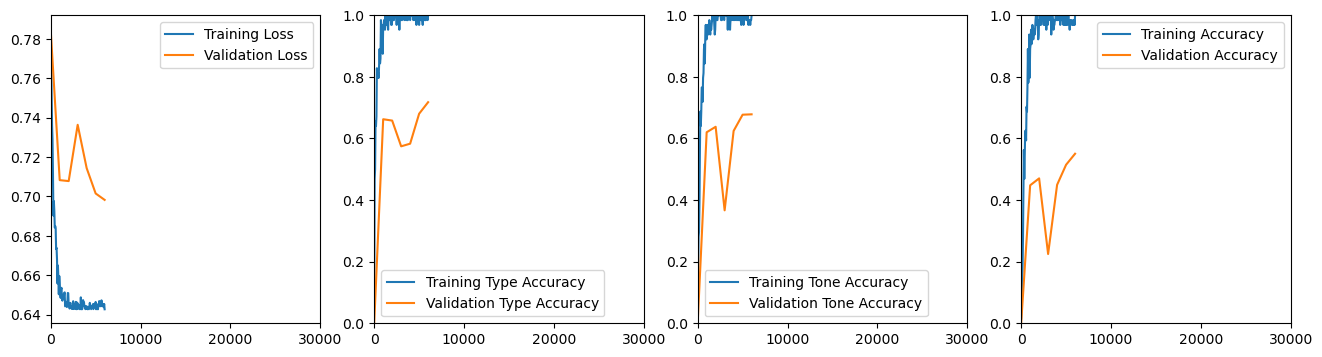

LR: 0.0005, L2: 1e-05, BS: 64, VS: 0.5


KeyboardInterrupt: 

In [206]:
NUM_BATCHES = 30000
EVAL_EVERY = 1000
LOG_TRAIN_EVERY = 50
NUM_VALIDATION_BATCHES = 100
LOG_EVERY = EVAL_EVERY

error_tracker = utils.ErrorTracker(criterion, eval_funcs, NUM_VALIDATION_BATCHES)

net.train()
for i, (signal, fft, target, label) in enumerate(itertools.islice(utils.cycle_data_loader(rw_training_loader), NUM_BATCHES+1)):
    if i%EVAL_EVERY == 0:
        error_tracker.validation_update(i, net, rw_validation_loader)

    signal = utils.to_torch(signal)
    fft = utils.to_torch(fft)
    target = utils.to_torch(target)
    output = net(signal, fft)
    loss = criterion(output, target)

    if i%LOG_TRAIN_EVERY == 0:
        error_tracker.training_update(i, output, target, label, loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if i % LOG_EVERY == 0:
        display.clear_output(wait=True)
        plots.plot_history(error_tracker, NUM_BATCHES, eval_funcs)
        plt.show()
        print(f"LR: {LEARNING_RATE}, L2: {WEIGHT_DECAY}, BS: {BATCH_SIZE}, VS: {VALIDATION_SPLIT}")
    #print(f"Batch: {i}", end="\r")
        

net.eval()
val_loss, [val_type_accuracy, val_tone_accuracy, val_accuracy] = utils.test_net(net, rw_validation_loader, criterion, NUM_VALIDATION_BATCHES, eval_funcs)

print(f"RW only={new_model}, Loss={val_loss}, Type Accuracy={val_type_accuracy:.3f}, Tone Accuracy={val_tone_accuracy:.3f}, Accuracy={val_accuracy:.3f}")

utils.manual_test(net, rw_validation_loader, 5, manual_test_funcs)

In [ ]:
#utils.save_model("C:/Users/alber/Google Drive/DTU/Deep Learning/data/", "rw_model3_400k_b.pt", net)